# HW5

### practice Support Vector Machine

- training
    - `X_train.csv`
        - image
        - 5000 * 784(28 * 28)
    - `T_train.csv`
        - label
        - 5000 * 1
- testing
    - `X_test.csv`
        - image
        - 2500 * 784(28 * 28)
    - `T_test.csv`
        - label
        - 2500 * 1

In [179]:
import numpy as np
from matplotlib import pyplot as plt
import libsvm.python.svm as svm
import libsvm.python.svmutil as svmutil
import scipy
import ctypes
import pandas as pd

In [ ]:
from time import time

start_tic_time = 0
def tic():
    start_tic_time = time()
    return start_tic_time

def toc():
    elapsed_time = time() - start_tic_time
    return elapsed_time

In [2]:
X_train = np.genfromtxt('X_train.csv', delimiter=',')
T_train = np.genfromtxt('T_train.csv', delimiter=',')
X_test = np.genfromtxt('X_test.csv', delimiter=',')
T_test = np.genfromtxt('T_test.csv', delimiter=',')

#### prepare data fit libsvm format

- in csv

```
label index:value index:value ...
label index:value index:value ...
```

- in python struct

```python
label = [1,2]
data = [{1:2,3:1},{3:2,10:1}]
```

In [356]:
def sparse_matrix(x, iskernel=False):
    row = x.shape[0]
    col = x.shape[1]
    idx_offset = 1
    if (iskernel):
        x = np.append(np.linspace(1,row,row), x).reshape(col+1,row).T
        idx_offset = 0
    x = [{idx+idx_offset:x[i][idx] for _,idx in np.ndenumerate(np.argwhere(x[i]!=0))} for i in range(x.shape[0])]
    return x

In [287]:
%%time
x_train = sparse_matrix(X_train)
y_train = list(T_train)
#x_train = [{idx+1:X_train[i][idx] for _,idx in np.ndenumerate(np.argwhere(X_train[i]!=0))} for i in range(X_train.shape[0])]

x_test = sparse_matrix(X_test)
y_test = list(T_test)
#x_test = [{idx+1:X_test[i][idx] for _,idx in np.ndenumerate(np.argwhere(X_test[i]!=0))} for i in range(X_test.shape[0])]

CPU times: user 2.05 s, sys: 24 ms, total: 2.07 s
Wall time: 2.07 s


### different kernel functions

- linear

$ K(u,v) = u^Tv$

- polynomial

$ K(u,v,c,d) = (u^Tv + c)^d$

- RBF

$ K(u,v,\gamma) = exp({-\gamma |u - v|^2}) $

#### libsvm option

```
options:
-s svm_type : set type of SVM (default 0)
	0 -- C-SVC
	1 -- nu-SVC
	2 -- one-class SVM
	3 -- epsilon-SVR
	4 -- nu-SVR
-t kernel_type : set type of kernel function (default 2)
	0 -- linear: u'*v
	1 -- polynomial: (gamma*u'*v + coef0)^degree
	2 -- radial basis function: exp(-gamma*|u-v|^2)
	3 -- sigmoid: tanh(gamma*u'*v + coef0)
-d degree : set degree in kernel function (default 3)
-g gamma : set gamma in kernel function (default 1/num_features)
-r coef0 : set coef0 in kernel function (default 0)
-c cost : set the parameter C of C-SVC, epsilon-SVR, and nu-SVR (default 1)
-n nu : set the parameter nu of nu-SVC, one-class SVM, and nu-SVR (default 0.5)
-p epsilon : set the epsilon in loss function of epsilon-SVR (default 0.1)
-m cachesize : set cache memory size in MB (default 100)
-e epsilon : set tolerance of termination criterion (default 0.001)
-h shrinking: whether to use the shrinking heuristics, 0 or 1 (default 1)
-b probability_estimates: whether to train a SVC or SVR model for probability estimates, 0 or 1 (default 0)
-wi weight: set the parameter C of class i to weight*C, for C-SVC (default 1)
```

[LIBSVM学习（六）代码结构及c-SVC过程](https://blog.csdn.net/u014772862/article/details/51835192)

In [72]:
m = {}
p_label = {}
p_acc = {}
p_val = {}

In [86]:
parastrs = {
    'linear' : '-t 0',
    'polynomial d=3 c=0' : '-t 1 -d 3 -r 0',
    'polynomial d=3 c=1' : '-t 1 -d 3 -r 1',
    'polynomial d=10 c=0' : '-t 1 -d 10 -r 0',
    'polynomial d=10 c=1' : '-t 1 -d 10 -r 1',
    'RBF g=0.0013' : '-t 2 -g 0.0013',
    'RBF g=0.0033' : '-t 2 -g 0.0033',
    'RBF g=0.5' : '-t 2 -g 0.5',
    'RBF g=1' : '-t 2 -g 1',
}

In [87]:
%%time

for kernel_type, opts in parastrs.items():
    if not (kernel_type in m):
        m[kernel_type] = svmutil.svm_train(y_train, x_train, opts)
        p_label[kernel_type], p_acc[kernel_type], p_val[kernel_type]= svmutil.svm_predict(y_test, x_test, m[kernel_type])
    else:
        print('Accuracy = {:.2f}% ({:d}/{:d}) (classification)'.format(p_acc[kernel_type][0], int((len(y_test)*p_acc[kernel_type][0])/100), int(len(y_test))))
        #print('')
    print('kernel type : {} , acc : {}\n'.format(kernel_type, p_acc[kernel_type]))

Accuracy = 95.08% (2377/2500) (classification)
kernel type : linear , acc : (95.08, 0.1404, 0.931149802516624)

Accuracy = 34.68% (867/2500) (classification)
kernel type : polynomial d=3 c=0 , acc : (34.68, 2.6212, 0.14887572191533946)

Accuracy = 95.76% (2394/2500) (classification)
kernel type : polynomial d=3 c=1 , acc : (95.76, 0.1356, 0.9336123460070571)

Accuracy = 20.72% (518/2500) (classification)
kernel type : polynomial d=10 c=0 , acc : (20.72, 2.9884, 0.007062945744989033)

Accuracy = 97.32% (2432/2500) (classification)
kernel type : polynomial d=10 c=1 , acc : (97.32, 0.0924, 0.954375041275707)

Accuracy = 95.32% (2383/2500) (classification)
kernel type : RBF g=0.0013 , acc : (95.32000000000001, 0.1492, 0.9271864783823697)

Accuracy = 96.36% (2409/2500) (classification)
kernel type : RBF g=0.0033 , acc : (96.36, 0.1188, 0.9415603861168684)

Accuracy = 43% (1075/2500) (classification)
kernel type : RBF g=0.5 , acc : (43.0, 1.5768, 0.219471432111856)

Accuracy = 30.04% (751/25

In [205]:
#help(svmutil.svm_train)

In [288]:
#help(svmutil.svm_problem)
prob = svmutil.svm_problem(y_train, x_train)

### use C-SVC

use grid search and cross-validation

```
-v n: n-fold cross validation mode
```

In [292]:
def GridSearchForSVM(kernel, parameter_matrix, problem, n_ford=10):
    opts = list(parameter_matrix.keys())
    opts_max = np.array([len(parameter_matrix[opts[i]]) for i in range(len(opts))])
    current_opt = np.array([0 for i in range(len(opts))])
    results = [];
    
    optstr_init = '-t {:d} -v {:d} '.format(int(kernel),int(n_ford))
    
    overflow = False
    while(True):
        while (np.count_nonzero(current_opt >= opts_max)):
            reset_indicator = np.argwhere(current_opt >= opts_max)
            current_opt[reset_indicator[-1]] -= opts_max[reset_indicator[-1]] 
            if (reset_indicator[-1]-1 < 0):
                overflow = True
                break;
            current_opt[reset_indicator[-1]-1] += 1
        
        if (overflow):
            break
        
        # gen option string
        optstr = optstr_init
        result = []
        for idx,para in enumerate(current_opt):
            optkey = opts[idx]
            optstr += '-' + str(optkey) + ' ' + str(parameter_matrix[optkey][para]) + ' '
            result.append(parameter_matrix[optkey][para])
        
        # get cross-validation result
        result.append(optstr)
        result.append(svmutil.svm_train(problem, optstr))
        
        results.append(result)
        # try next options
        current_opt[-1] += 1
    
    opts += ['opt str', 'result']
    return results, opts

In [344]:
%%time
linear_results, linear_options = GridSearchForSVM(0, {'c' : [10**-5,10**-2,1,10**2,10**5]}, prob)

Cross Validation Accuracy = 79.32%
Cross Validation Accuracy = 97.06%
Cross Validation Accuracy = 96.24%
Cross Validation Accuracy = 96.32%
Cross Validation Accuracy = 96.28%
CPU times: user 7min 11s, sys: 87.7 ms, total: 7min 11s
Wall time: 7min 11s


In [345]:
linear_table = pd.DataFrame(linear_results, columns=linear_options)

linear_table.to_csv('linear_results.csv')

display(linear_table.sort_values(by=['result'], ascending=False))

,c,opt str,result
1,0.01000,-t 0 -v 10 -c 0.01,97.06
3,100.00000,-t 0 -v 10 -c 100,96.32
4,100000.00000,-t 0 -v 10 -c 100000,96.28
2,1.00000,-t 0 -v 10 -c 1,96.24
0,0.00001,-t 0 -v 10 -c 1e-05,79.32


In [346]:
#pd.read_csv('linear_results.csv', index_col=0)

In [347]:
%%time
poly_results, poly_options = GridSearchForSVM(1, {'c' : [10**-2,1,10**2],'r' : [0,1],'d' : [2,3,4,10]}, prob)

Cross Validation Accuracy = 45.48%
Cross Validation Accuracy = 28.24%
Cross Validation Accuracy = 23.48%
Cross Validation Accuracy = 20.5%
Cross Validation Accuracy = 78.22%
Cross Validation Accuracy = 81.12%
Cross Validation Accuracy = 85.8%
Cross Validation Accuracy = 92.4%
Cross Validation Accuracy = 87.04%
Cross Validation Accuracy = 33.84%
Cross Validation Accuracy = 23.42%
Cross Validation Accuracy = 20.5%
Cross Validation Accuracy = 96.34%
Cross Validation Accuracy = 96.78%
Cross Validation Accuracy = 97.1%
Cross Validation Accuracy = 97.7%
Cross Validation Accuracy = 97.76%
Cross Validation Accuracy = 93.34%
Cross Validation Accuracy = 68.16%
Cross Validation Accuracy = 20.48%
Cross Validation Accuracy = 97.04%
Cross Validation Accuracy = 97.36%
Cross Validation Accuracy = 97.3%
Cross Validation Accuracy = 97.84%
CPU times: user 1h 16min 9s, sys: 1.49 s, total: 1h 16min 11s
Wall time: 1h 16min 14s


In [231]:
poly_table = pd.DataFrame(poly_results, columns=poly_options)

poly_table.to_csv('poly_results.csv')

display(poly_table.sort_values(by=['result'], ascending=False))

,c,r,d,opt str,result
23,100.00,1,10,-t 1 -v 10 -c 100 -r 1 -d 10,97.82
16,100.00,0,2,-t 1 -v 10 -c 100 -r 0 -d 2,97.76
15,1.00,1,10,-t 1 -v 10 -c 1 -r 1 -d 10,97.76
22,100.00,1,4,-t 1 -v 10 -c 100 -r 1 -d 4,97.52
21,100.00,1,3,-t 1 -v 10 -c 100 -r 1 -d 3,97.28
20,100.00,1,2,-t 1 -v 10 -c 100 -r 1 -d 2,97.04
14,1.00,1,4,-t 1 -v 10 -c 1 -r 1 -d 4,96.98
13,1.00,1,3,-t 1 -v 10 -c 1 -r 1 -d 3,96.84
12,1.00,1,2,-t 1 -v 10 -c 1 -r 1 -d 2,96.42
17,100.00,0,3,-t 1 -v 10 -c 100 -r 0 -d 3,93.36


In [348]:
%%time
rbf_results, rbf_options = GridSearchForSVM(2, {'c' : [10**-2,1,10**2],'g' : [1/100,1/300,1/784]}, prob)

Cross Validation Accuracy = 92.82%
Cross Validation Accuracy = 86.98%
Cross Validation Accuracy = 81.26%
Cross Validation Accuracy = 97.92%
Cross Validation Accuracy = 97.3%
Cross Validation Accuracy = 96.28%
Cross Validation Accuracy = 98.24%
Cross Validation Accuracy = 97.84%
Cross Validation Accuracy = 97.5%
CPU times: user 19min 49s, sys: 536 ms, total: 19min 49s
Wall time: 19min 50s


In [232]:
rbf_table = pd.DataFrame(rbf_results, columns=rbf_options)

rbf_table.to_csv('rbf_results.csv')

display(rbf_table.sort_values(by=['result'], ascending=False))

,c,g,opt str,result
6,100.00,0.010000,-t 2 -v 10 -c 100 -g 0.01,98.38
7,100.00,0.003333,-t 2 -v 10 -c 100 -g 0.0033333333333333335,97.86
3,1.00,0.010000,-t 2 -v 10 -c 1 -g 0.01,97.80
8,100.00,0.001276,-t 2 -v 10 -c 100 -g 0.0012755102040816326,97.56
4,1.00,0.003333,-t 2 -v 10 -c 1 -g 0.0033333333333333335,97.30
5,1.00,0.001276,-t 2 -v 10 -c 1 -g 0.0012755102040816326,96.42
0,0.01,0.010000,-t 2 -v 10 -c 0.01 -g 0.01,92.74
1,0.01,0.003333,-t 2 -v 10 -c 0.01 -g 0.0033333333333333335,87.12
2,0.01,0.001276,-t 2 -v 10 -c 0.01 -g 0.0012755102040816326,81.14


### linear + RBF kernel

use precomputed data

```
New training instance for xi:

<label> 0:i 1:K(xi,x1) ... L:K(xi,xL)
```

- problem option
```
iskernel = True
```
- train option
```
    -t 4 precomputed kernel
```

In [349]:
def dot_square(x):
    return np.dot(x, x)

def linear_RBF_kernel(u, v, gamma=0.01):
    design_x = np.matmul(u, v.T)
    rbf_design_x = [[dot_square(u_i-v_i)*(-gamma) for v_i in v] for u_i in u]
    rbf_design_x = np.exp(rbf_design_x)
    design_x = design_x + rbf_design_x
    return design_x

In [350]:
%%time
x_train_precomputed = linear_RBF_kernel(X_train, X_train)

CPU times: user 2min 20s, sys: 1.64 s, total: 2min 21s
Wall time: 2min 16s


In [351]:
%%time
x_train_precomputed = sparse_matrix(x_train_precomputed, iskernel=True)

CPU times: user 39.7 s, sys: 536 ms, total: 40.2 s
Wall time: 40.3 s


In [303]:
prob_precomputed = svmutil.svm_problem(y_train, x_train_precomputed, isKernel=True)

In [358]:
%%time
x_test_precomputed = linear_RBF_kernel(X_test, X_train)
x_test_precomputed = sparse_matrix(x_test_precomputed, iskernel=True)

CPU times: user 1min 34s, sys: 1.42 s, total: 1min 35s
Wall time: 1min 30s


In [341]:
%%time
linear_rbf_results, linear_rbf_options = GridSearchForSVM(4, {'c' : np.logspace(-6,6,10)}, prob_precomputed)

Cross Validation Accuracy = 79.38%
Cross Validation Accuracy = 79.38%
Cross Validation Accuracy = 94.72%
Cross Validation Accuracy = 97.06%
Cross Validation Accuracy = 96.88%
Cross Validation Accuracy = 96.48%
Cross Validation Accuracy = 96.46%
Cross Validation Accuracy = 96.38%
Cross Validation Accuracy = 96.08%
Cross Validation Accuracy = 96.56%
CPU times: user 39 s, sys: 67.9 ms, total: 39.1 s
Wall time: 39.1 s


In [342]:
linear_rbf_table = pd.DataFrame(linear_rbf_results, columns=linear_rbf_options)

linear_rbf_table.to_csv('linear_rbf_results.csv')

display(linear_rbf_table.sort_values(by=['result'], ascending=False))

,c,opt str,result
3,0.010000,-t 4 -v 10 -c 0.01,97.06
4,0.215443,-t 4 -v 10 -c 0.21544346900318823,96.88
9,1000000.000000,-t 4 -v 10 -c 1000000.0,96.56
5,4.641589,-t 4 -v 10 -c 4.641588833612772,96.48
6,100.000000,-t 4 -v 10 -c 100.0,96.46
7,2154.434690,-t 4 -v 10 -c 2154.434690031878,96.38
8,46415.888336,-t 4 -v 10 -c 46415.888336127726,96.08
2,0.000464,-t 4 -v 10 -c 0.00046415888336127773,94.72
0,0.000001,-t 4 -v 10 -c 1e-06,79.38
1,0.000022,-t 4 -v 10 -c 2.1544346900318823e-05,79.38


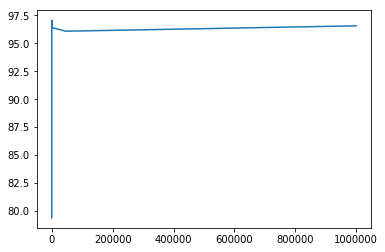

In [343]:
plt.plot(linear_rbf_table['c'], linear_rbf_table['result'])

In [ ]:
m = {}
p_label = {}
p_acc = {}
p_val = {}

In [ ]:
parastrs = {
    'linear' : '-t 0 -c 0.01',
    'polynomial' : '-t 1  -c 100 -r 1 -d 10',
    'RBF' : '-t 2  -c 100 -g 0.01',
}
parastrs_precomputed = {
    'linear+RBF' : '-t 4 -c 0.01',
}

In [ ]:
%%time

for kernel_type, opts in parastrs.items():
    if not (kernel_type in m):
        m[kernel_type] = svmutil.svm_train(y_train, x_train, opts)
        p_label[kernel_type], p_acc[kernel_type], p_val[kernel_type]= svmutil.svm_predict(y_test, x_test, m[kernel_type])
    else:
        print('Accuracy = {:.2f}% ({:d}/{:d}) (classification)'.format(p_acc[kernel_type][0], int((len(y_test)*p_acc[kernel_type][0])/100), int(len(y_test))))
        #print('')
    print('kernel type : {} , acc : {}\n'.format(kernel_type, p_acc[kernel_type]))
    
for kernel_type, opts in parastrs_precomputed.items():
    if not (kernel_type in m):
        m[kernel_type] = svmutil.svm_train(y_train, x_train_precomputed, opts)
        p_label[kernel_type], p_acc[kernel_type], p_val[kernel_type]= svmutil.svm_predict(y_test, x_test_precomputed, m[kernel_type])
    else:
        print('Accuracy = {:.2f}% ({:d}/{:d}) (classification)'.format(p_acc[kernel_type][0], int((len(y_test)*p_acc[kernel_type][0])/100), int(len(y_test))))
        #print('')
    print('kernel type : {} , acc : {}\n'.format(kernel_type, p_acc[kernel_type]))

### report

compare 4 diff kernel model

- accuracy
- number of support vector
- train time
- test time